# 4-1. 6개월평균모멘텀 & SYSTEM STOP 만들기

In [1]:
import pandas as pd
import numpy as np

### 함수

In [2]:
def 월별수익(data):
    result = data/data.shift(1)
    return result

def 절대모멘텀(data,month):
    # shift를 사용하여 원화는 달의 수익률을 구한다
    # 당월주가 > n 개월 전 주가(n개월 모멘텀 > 0) --> 주식매수
    # 당월주가 < n 개월 전 주가(n개월 모멘텀 < 0) --> 주식매도
    result = np.where(data/data.shift(month)>1,1,0)
    return result

def CAGR(data):
    y = data.index.year.unique()
    result = (data[-1]/data[0])**(1/len(y))-1
    return np.round(result,4)

def MDD(data):
    window = len(data)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = data.rolling(window, min_periods=1).max()
    Roll_Max.rename("Roll_Max", inplace=True)
    Drawdown = data/Roll_Max - 1.0
    Drawdown.rename("Drawdown", inplace=True)

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Drawdown = Drawdown.rolling(window, min_periods=1).min()
    Max_Drawdown.rename("Max_Drawdown", inplace=True)
    
    return np.round(Drawdown,4), np.round(Max_Drawdown,4)

### 6개월평균 절대모멘텀

In [3]:
def 개월6평균절대모멘텀(data):
    # shift를 사용하여 원화는 달의 수익률을 구한다
    # 당월주가 > n 개월 전 주가(n개월 모멘텀 > 0) --> 주식매수
    # 당월주가 < n 개월 전 주가(n개월 모멘텀 < 0) --> 주식매도
    result = 0
    for i in range(1,7):
        result += np.where(data/data.shift(i)>1,1,0) 
    return np.round(result/6,2)  #6개월 평균값 return

# Main

### csv 파일 읽어오기

In [4]:
df = pd.read_csv("kospi_monthly_total_data.csv", encoding="utf-8")

### Index는 datetime 형으로 변환하기

In [5]:
df.index = pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
1980-01-31,1980-01-31,100.00,106.87,100.00,105.89,NaN
1980-02-29,1980-02-29,104.48,106.08,103.46,103.74,NaN
1980-03-31,1980-03-31,103.96,107.22,102.76,105.00,NaN
1980-04-30,1980-04-30,105.43,118.21,105.43,116.09,NaN
1980-05-30,1980-05-30,116.54,119.36,109.47,116.43,NaN


### 구간 데이타 만들기

In [6]:
#df = df["2015"]

### 6개월평균 절대모멘텀 값 구하기, CAGR/MDD 구하기

In [7]:
KOSPI = df["Close"]
KOSPI.rename("KOSPI", inplace=True)
KOSPI = KOSPI/KOSPI[0] * 1  #re-scale로 1로 맞춤
KOSPI_CAGR = CAGR(KOSPI) # CAGR 구하기
KOSPI_DD,KOSPI_MDD  = MDD(KOSPI)  # MDD 구하기
누적월별수익 = 월별수익(KOSPI).cumprod()  #누적수익률 구하기
print ("KOSPI CAGR {:.2%} ".format(KOSPI_CAGR))
print ("KOSPI MDD {:.2%}".format(KOSPI_MDD.min()))
print ("누적월별수익 {:.2%}".format(누적월별수익[-1]))
print ("")

KOSPI CAGR 7.79% 
KOSPI MDD -73.06%
누적월별수익 2006.12%



### 수익곡선 & 6개월 평균 모멘텀을 결합한 모멘텀 전략
1.6개월 평균 모멘텀 스코어가 수익곡선 값보다 작으면 system stop

2.6개월 평균 모멘텀 스코어가 수익곡선 값보다 크면 system go

### virtual trading 구하기

In [8]:
#실제 거래가 발생하는 자본금 = real_trading_자본금, system stop 그래프 = virtual_trading_자본금
virtual_trading_자본금 = [1]
system_stop = []
매수금액 = 0
매매금액= 0

score = 개월6평균절대모멘텀(KOSPI)  #6개월 절대모멘텀 구하기
월수익 = 월별수익(KOSPI)

for i in range(0,len(score)):
    # 첫달 매수금액
    매수금액 = score[i] * virtual_trading_자본금[i]
    try:        
        #두번째달 수익과 첫달 매수금액 곱하기
        매매금액 = 매수금액 * 월수익[i+1]
        #첫달 자본금으로 두번째달 월별수익을 곱하여 손익을 계산하고 두번째달 자본금으로 할당함.
        virtual_trading_자본금.append((virtual_trading_자본금[i] - 매수금액) + 매매금액)  #현금 = 자본금 - 매수금액
    except IndexError:  #마지막달 매수금액의 투자수익은 구할수없어 pass 처리함
        pass

In [9]:
virtual_trading_자본금 = pd.DataFrame(virtual_trading_자본금, index=KOSPI.index)
type(virtual_trading_자본금[0])

pandas.core.series.Series

### system stop

In [10]:
#system_stop = virtual_trading_자본금.apply(lambda x: x.rolling(window=6, min_periods=1).mean())
system_stop = virtual_trading_자본금.apply(lambda x: x.rolling(window=6).mean())
system_stop.head(10)

,0
Date,
1980-01-31,NaN
1980-02-29,NaN
1980-03-31,NaN
1980-04-30,NaN
1980-05-30,NaN
1980-06-30,1.005749
1980-07-31,1.005332
1980-08-29,1.004854
1980-09-30,1.002681


In [11]:
type(virtual_trading_자본금[0])

pandas.core.series.Series

In [12]:
type(system_stop[0])

pandas.core.series.Series

In [13]:
type(score[0])

numpy.float64

### real trading 구하기

In [14]:
매수금액 = 0
매매금액= 0
real_trading_자본금 = [1]  #첫달 자본금 1로 설정

for i in range(0,len(score)-1):
    # virtual_trading_자본금 > system_stop이면 매매거래
    if virtual_trading_자본금[0][i] > system_stop[0][i]:
        # 첫달 매수금액
        매수금액 = score[i] * real_trading_자본금[i]
        try:        
            #두번째달 수익과 첫달 매수금액 곱하기
            매매금액 = 매수금액 * 월수익[i+1]
            #첫달 자본금으로 두번째달 월별수익을 곱하여 손익을 계산하고 두번째달 자본금으로 할당함.
            real_trading_자본금.append((real_trading_자본금[i] - 매수금액) + 매매금액)  #현금 = 자본금 - 매수금액
        except IndexError:  #마지막달 매수금액의 투자수익은 구할수없어 pass 처리함
            pass
    else:
        real_trading_자본금.append(real_trading_자본금[i])

In [15]:
real_trading_자본금 = pd.DataFrame(real_trading_자본금, index=KOSPI.index)

### 자본과 수익곡선 그래프 그리기

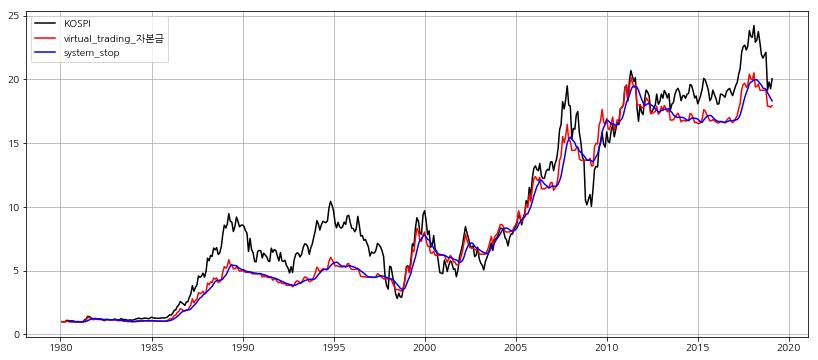

In [16]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")
%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(KOSPI,color="Black",label="KOSPI")
ax.plot(virtual_trading_자본금,color="red",label="virtual_trading_자본금")
ax.plot(system_stop,color="blue",label="system_stop")
ax.grid(True)
ax.legend();

In [17]:
virtual_trading_자본금CAGR = CAGR(virtual_trading_자본금[0])
virtual_trading_자본금DD, virtual_trading_자본금MDD = MDD(virtual_trading_자본금[0])
real_trading_자본금CAGR = CAGR(real_trading_자본금[0])
real_trading_자본금DD, real_trading_자본금MDD = MDD(real_trading_자본금[0])

In [18]:
print ("KOSPI CAGR {:.2%} ".format(KOSPI_CAGR))
print ("KOSPI MDD {:.2%}".format(KOSPI_MDD.min()))
print ("누적월별수익 {:.2%}".format(누적월별수익[-1]))
print ("")

print ("virtual CAGR {:.2%} ".format(virtual_trading_자본금CAGR))
print ("virtual MDD {:.2%}".format(virtual_trading_자본금MDD.min()))
print ("virtual 누적월별수익 {:.2%}".format(virtual_trading_자본금[0][-1]))
print ("")

print ("real_trading CAGR {:.2%} ".format(real_trading_자본금CAGR))
print ("real_trading MDD {:.2%}".format(real_trading_자본금MDD.min()))
print ("real_trading 누적월별수익 {:.2%}".format(real_trading_자본금[0][-1]))

KOSPI CAGR 7.79% 
KOSPI MDD -73.06%
누적월별수익 2006.12%

virtual CAGR 7.49% 
virtual MDD -43.53%
virtual 누적월별수익 1794.56%

real_trading CAGR 7.00% 
real_trading MDD -25.89%
real_trading 누적월별수익 1496.37%


### score 그래프

In [19]:
df_score = pd.DataFrame(score, index=KOSPI.index)

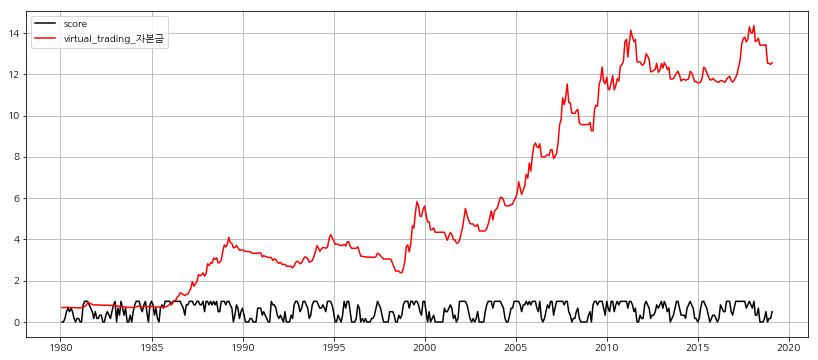

In [20]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")
%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(df_score,color="black",label="score")
ax.plot(virtual_trading_자본금*0.7,color="red",label="virtual_trading_자본금")
ax.grid(True)
ax.legend();

### real trading & virtual trading 그래프 그리기
12개월평균스코어 & 6개월평균스코어 차이는 많이 난다. 그것은 자본금대비 투자되는 비율이 1/2차이가 나기 때문이다.

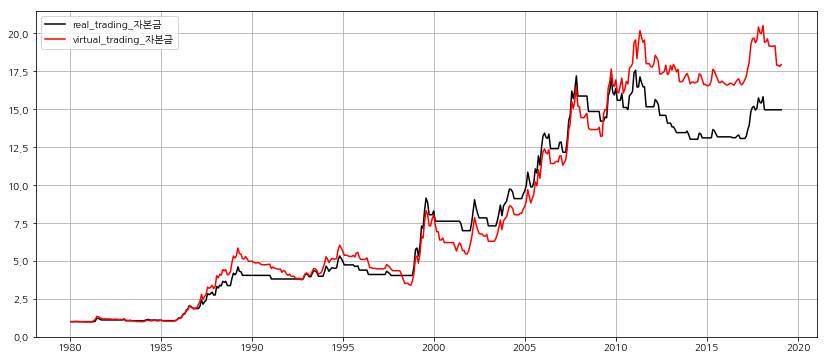

In [21]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")
%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(real_trading_자본금,color="black",label="real_trading_자본금")
ax.plot(virtual_trading_자본금,color="red",label="virtual_trading_자본금")
#ax.plot(system_stop,color="blue",label="system_stop")
ax.grid(True)
ax.legend();

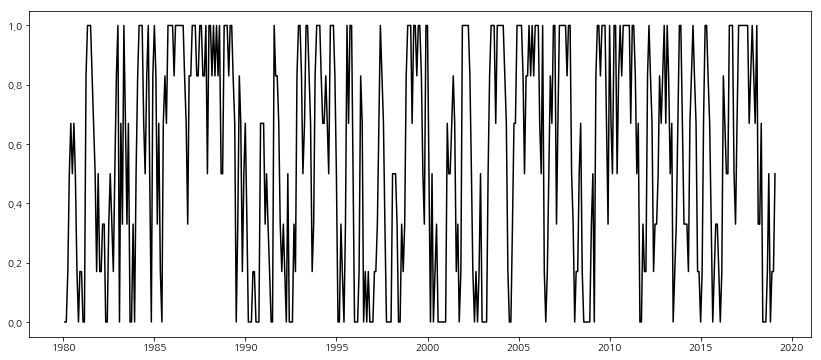

In [22]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(df_score,color="black",label="score");

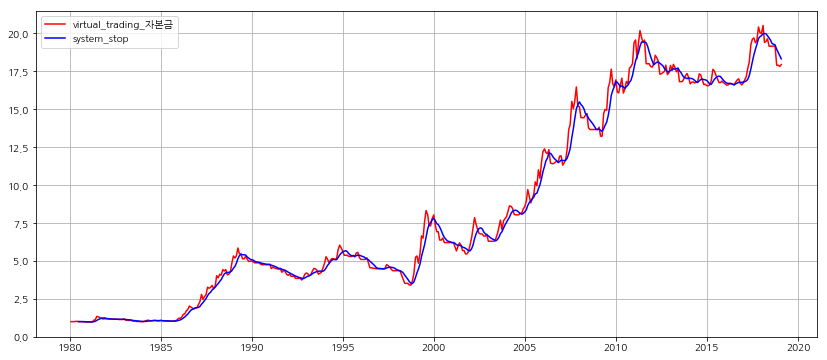

In [23]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")
%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
#ax.plot(real_trading_자본금,color="black",label="real_trading_자본금")
ax.plot(virtual_trading_자본금,color="red",label="virtual_trading_자본금")
ax.plot(system_stop,color="blue",label="system_stop")
ax.grid(True)
ax.legend();

### Monthly MDD & Max MDD

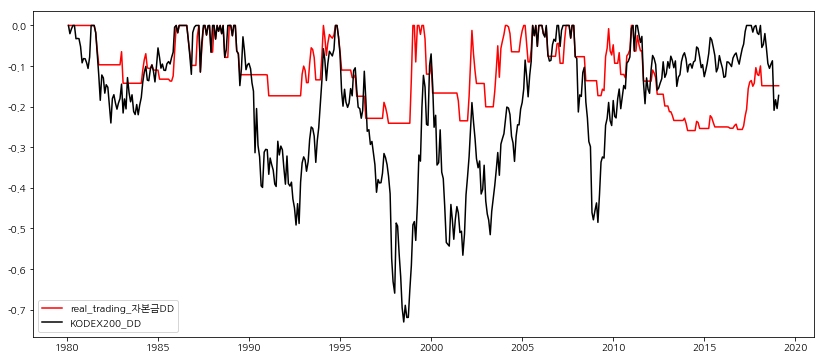

In [24]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(real_trading_자본금DD,color="Red",label="real_trading_자본금DD");
ax.plot(KOSPI_DD,color="Black", label="KODEX200_DD");
ax.legend();